In [1]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download mdwaquarazam/agricultural-crops-image-classification

 82% 65.0M/79.0M [00:00<00:00, 72.6MB/s]
100% 79.0M/79.0M [00:01<00:00, 80.6MB/s]


In [5]:
! unzip agricultural-crops-image-classification

Archive:  agricultural-crops-image-classification.zip
  inflating: Agricultural-crops/Cherry/image15.jpeg  
  inflating: Agricultural-crops/Cherry/image16.jpeg  
  inflating: Agricultural-crops/Cherry/image17.jpeg  
  inflating: Agricultural-crops/Cherry/image18.jpeg  
  inflating: Agricultural-crops/Cherry/image20.jpeg  
  inflating: Agricultural-crops/Cherry/image21.jpeg  
  inflating: Agricultural-crops/Cherry/image22.jpeg  
  inflating: Agricultural-crops/Cherry/image24.jpeg  
  inflating: Agricultural-crops/Cherry/image25.jpeg  
  inflating: Agricultural-crops/Cherry/image27.jpeg  
  inflating: Agricultural-crops/Cherry/image28.jpeg  
  inflating: Agricultural-crops/Cherry/image29.jpeg  
  inflating: Agricultural-crops/Cherry/image30.jpeg  
  inflating: Agricultural-crops/Cherry/image31.jpeg  
  inflating: Agricultural-crops/Cherry/images11.jpg  
  inflating: Agricultural-crops/Cherry/images16.jpg  
  inflating: Agricultural-crops/Cherry/images17.jpg  
  inflating: Agricultural-cr

In [6]:
import os
base_dir = os.path.join('/content/Agricultural-crops/')
labels = os.listdir('/content/Agricultural-crops/')
print(labels)
os.chdir(base_dir)

['jute', 'pineapple', 'Lemon', 'Coffee-plant', 'tomato', 'papaya', 'Olive-tree', 'mustard-oil', 'maize', 'cardamom', 'chilli', 'sugarcane', 'tea', 'wheat', 'Pearl_millet(bajra)', 'Tobacco-plant', 'banana', 'cotton', 'Cherry', 'gram', 'soyabean', 'coconut', 'Cucumber', 'vigna-radiati(Mung)', 'clove', 'rice', 'Fox_nut(Makhana)', 'jowar', 'sunflower', 'almond']


In [7]:
# to list every directory name (label)
directories_list = tf.io.gfile.listdir(base_dir)

# get number of labels
len_labels = len(directories_list)
print(f"Total Class Labels = {len_labels}")

vis_images = []; vis_labels=[]
length_file_list = []; label_list = []

for item in directories_list:

  # get each lable directories
  item_dir = os.path.join(base_dir, item)
  # get list of images of each label
  item_files = os.listdir(item)
  # number of images per label
  len_per_label = len(os.listdir(item))

  length_file_list.append(len_per_label)
  label_list.append(item)

  # get first image of each label (for visualisation purpose)
  vis_images.append(os.path.join(item_dir, item_files[0]))
  # get respective label name ( for visualisation purpose)
  vis_labels.append(item)

df_temp = pd.DataFrame({'Labels' :label_list, 'Number of Images' :length_file_list}).\
sort_values(by='Number of Images', ascending=False)
df_temp

Total Class Labels = 30


,Labels,Number of Images
14,Pearl_millet(bajra),39
15,Tobacco-plant,33
18,Cherry,32
17,cotton,32
22,Cucumber,31
16,banana,31
8,maize,31
13,wheat,31
24,clove,30
20,soyabean,30


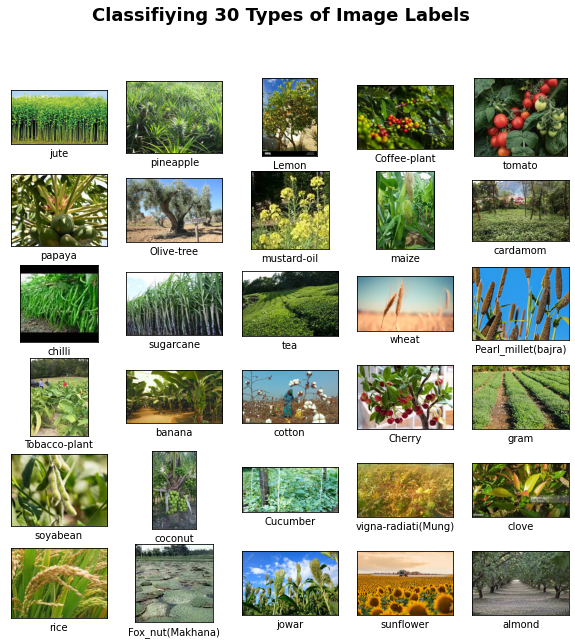

In [8]:
plt.figure(figsize=(10,10))
for i in range(len(vis_labels)):
  plt.subplot(6,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img = mpimg.imread(vis_images[i])
  plt.imshow(img)
  plt.xlabel(vis_labels[i])
  plt.suptitle(f"Classifiying {len_labels} Types of Image Labels", fontsize=18, fontweight='bold')
plt.show()

**Issues to be solved:**

*   We can see that the images are not in the same size
  *   Sol: Use ImageDataGenerator target size to standardise input size
*   Very low number of images to be trained, i.e., 20 to 40 images per label
  *   Sol: Add predictive power using Transfer Learning and ImageDataGenerator
*   Large number of classifying labels
  *   Sol: Use Transfer Learning and set appropriate architecture
*   Images not split for train and test
  *   Sol: Randomly Split the data first before training


In [9]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

    selected_file_names = []
    all_file_names = os.listdir(SOURCE_DIR)
    for file_name in all_file_names:
        file_path = os.path.join(SOURCE_DIR, file_name)
        size = os.path.getsize(file_path)
        if size != 0:
              selected_file_names.append(file_name)
        else:
              print(f"{file_name} is zero length, so ignoring.")

    random.seed(42)
    selected_train_files = random.sample(selected_file_names, int(SPLIT_SIZE * len(selected_file_names)))
    selected_val_files = [x for x in selected_file_names if x not in selected_train_files]

    for file_name in selected_train_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(TRAINING_DIR, file_name)
        copyfile(source, destination)

    for file_name in selected_val_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(VALIDATION_DIR, file_name)
        copyfile(source, destination)

In [10]:
def create_train_val_dirs(root_path, split_size = 0.9):
    for item in directories_list:
        source_dir = os.path.join(base_dir, item)
        training_dir = os.path.join(root_path, f'_MODELLING/training/{item}')
        validation_dir = os.path.join(root_path, f'_MODELLING/validation/{item}')

        # Create EMPTY directory
        os.makedirs(training_dir)
        os.makedirs(validation_dir)
        
        split_data(source_dir, training_dir, validation_dir, split_size)
    print(f"Created training and validation directories containing images at split size of {split_size}")

In [11]:
create_train_val_dirs('/content', split_size = 0.9)

Created training and validation directories containing images at split size of 0.9


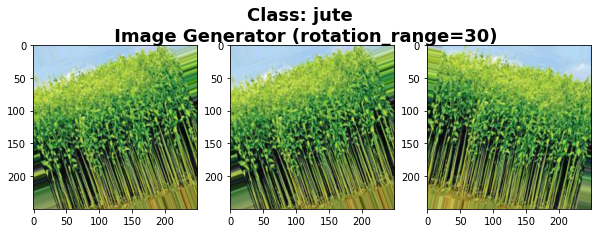

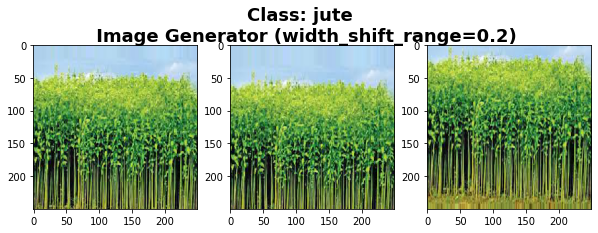

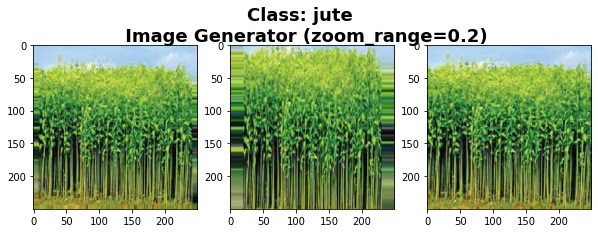

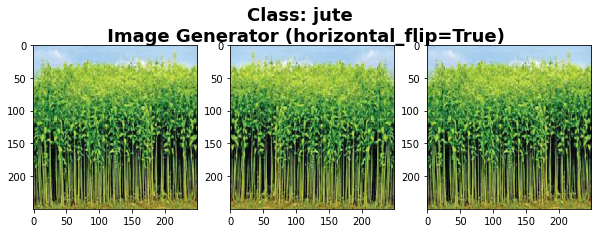

In [12]:
def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    #Loads image in from the set image path
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size= (250,250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    #Creates our batch of one image
    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size =1)
        plt.figure(figsize=(10,3.5))
        #Plots our figures
        for i in range(1,4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})",fontsize=18, fontweight='bold')

        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")

show_ImageDataGenerator(vis_images, vis_labels, image_index = 0)

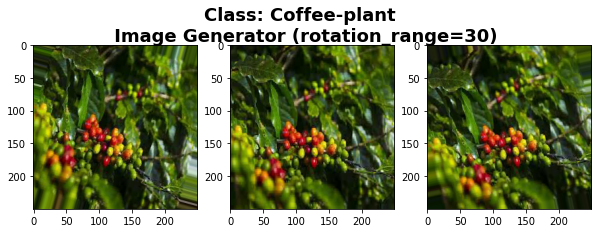

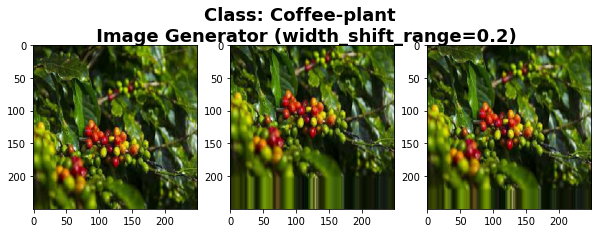

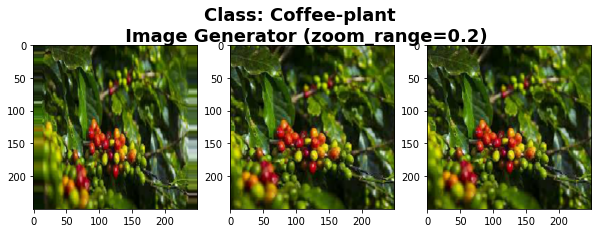

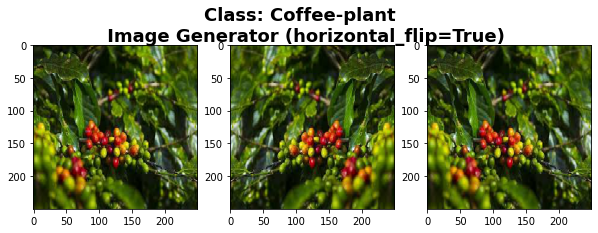

In [13]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 3)

In [14]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
    train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='binary',
                                                      target_size=(224, 224))

    # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(224, 224))
    return train_generator, validation_generator

In [15]:
training_dir = os.path.join('/content/', '_MODELLING', 'training')
validation_dir = os.path.join('/content/', '_MODELLING', 'validation')

print(validation_dir)

/content/_MODELLING/validation


In [16]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 731 images belonging to 30 classes.
Found 98 images belonging to 30 classes.


In [32]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = inception_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [33]:
import tensorflow_hub as hub
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [34]:
num_classes = len(directories_list)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 30)                30750     
                                                                 
Total params: 23,931,710
Trainable params: 2,128,926
Non-trainable params: 21,802,784
_________________________________________________________________


In [35]:
predictions = model(image_batch)

In [36]:
predictions.shape

TensorShape([32, 30])

In [37]:
last_output = feature_extractor_layer.output
print('last layer output: ', last_output)

# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(feature_extractor_layer)}")

last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 2048), dtype=tf.float32, name=None), name='keras_layer_1/StatefulPartitionedCall:0', description="created by layer 'keras_layer_1'")
The pretrained model has type: <class 'tensorflow_hub.keras_layer.KerasLayer'>


In [38]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [39]:
# Define a Callback class that stops training once accuracy reaches 80%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [40]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    callbacks=callbacks)

Epoch 1/20
23/23 [==============================] - 111s 5s/step - loss: 3.8481 - accuracy: 0.1696 - val_loss: 2.2858 - val_accuracy: 0.4082
Epoch 2/20
23/23 [==============================] - 105s 5s/step - loss: 2.0344 - accuracy: 0.4391 - val_loss: 1.7658 - val_accuracy: 0.5408
Epoch 3/20
23/23 [==============================] - 105s 5s/step - loss: 1.5767 - accuracy: 0.5513 - val_loss: 1.8462 - val_accuracy: 0.4694
Epoch 4/20
23/23 [==============================] - 103s 4s/step - loss: 1.4663 - accuracy: 0.5746 - val_loss: 1.4377 - val_accuracy: 0.5918
Epoch 5/20
23/23 [==============================] - 103s 4s/step - loss: 1.2247 - accuracy: 0.6471 - val_loss: 1.4363 - val_accuracy: 0.6020
Epoch 6/20
23/23 [==============================] - 105s 5s/step - loss: 1.1170 - accuracy: 0.6566 - val_loss: 1.3491 - val_accuracy: 0.6531
Epoch 7/20
23/23 [==============================] - 104s 5s/step - loss: 0.9992 - accuracy: 0.6949 - val_loss: 1.2441 - val_accuracy: 0.6531
Epoch 8/20
23

In [41]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()

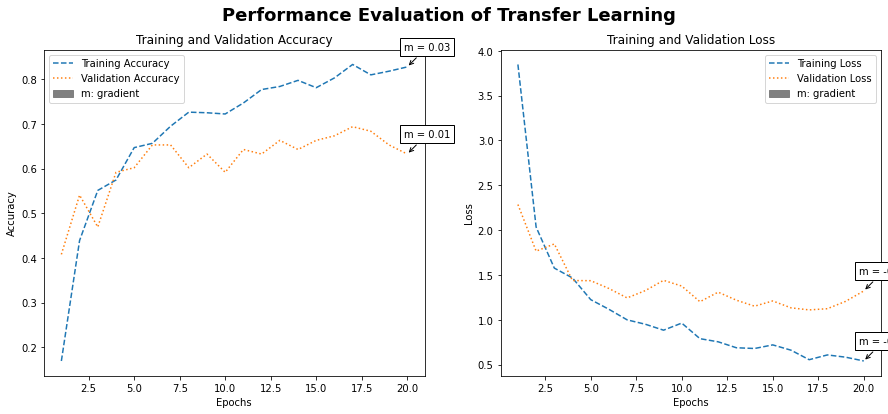

In [42]:
history_dict = history.history
vis_evaluation(history_dict, 'Transfer Learning')

In [43]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [48]:
class_names = np.array(directories_list)
print(class_names)
print(labels_batch)
print(len(class_names))

['jute' 'pineapple' 'Lemon' 'Coffee-plant' 'tomato' 'papaya' 'Olive-tree'
 'mustard-oil' 'maize' 'cardamom' 'chilli' 'sugarcane' 'tea' 'wheat'
 'Pearl_millet(bajra)' 'Tobacco-plant' 'banana' 'cotton' 'Cherry' 'gram'
 'soyabean' 'coconut' 'Cucumber' 'vigna-radiati(Mung)' 'clove' 'rice'
 'Fox_nut(Makhana)' 'jowar' 'sunflower' 'almond']
[ 4.  1.  0. 26. 10.  6.  6. 22.  6. 20. 25. 27.  4.  3. 29. 18. 16. 10.
 28.  0. 23. 13.  6.  2.  9. 28. 17. 18. 16. 16.  5. 15.]
30


In [45]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 4s 4s/step
['tomato' 'pineapple' 'jute' 'mustard-oil' 'chilli' 'Olive-tree'
 'Olive-tree' 'Cucumber' 'Olive-tree' 'soyabean' 'rice' 'jowar' 'tomato'
 'Coffee-plant' 'almond' 'Cherry' 'banana' 'chilli' 'Tobacco-plant' 'jute'
 'vigna-radiati(Mung)' 'wheat' 'cardamom' 'Lemon' 'cardamom' 'sunflower'
 'cotton' 'Lemon' 'banana' 'banana' 'papaya' 'Tobacco-plant']


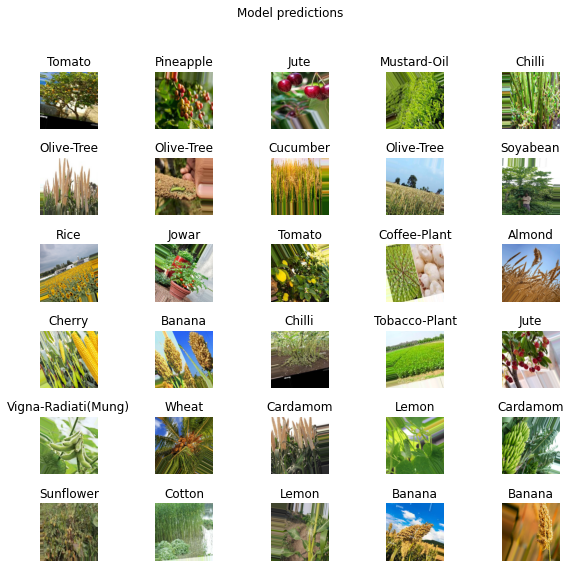

In [46]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")